[View in Colaboratory](https://colab.research.google.com/github/sungreong/Pymc3_bayseian/blob/master/A_Primer_on_Bayesian_Methods_for_Multilevel_Modeling(1)_.ipynb)

In [3]:
!pip install git+https://github.com/pymc-devs/pymc3

  Cloning https://github.com/pymc-devs/pymc3 to /tmp/pip-req-build-cloegya9
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/99/dd/e43e3da5dd52f1468def552ed3e752bfd6958369478cc906ff07b21af92e/Theano-1.0.2.tar.gz
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/4f/51/870b2ec270fc29c5d89f85353da420606a9cb39fba4747127e7c7d7eb25d/joblib-0.11-py2.py3-none-any.whl
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/93/24/6ab1df969db228aed36a648a8959d1027099ce45fad67532b9673d533318/tqdm-4.23.4-py2.py3-none-any.whl
  Running setup.py bdist_wheel for pymc3 ... - \ | / - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-11xeepl1/wheels/a1/e3/71/a696f2af0dd40bccc0ce672d616d21cc9dd90dbdd3f03242f4
  Running setup.py bdist_wheel for theano ... - \ | / - \ | / done
  Stored in directory: /content/.cach

Hierarchical or multilevel modeling is a generalization of regression modeling  


다중 레벨 모델은 구성 모델 매개 변수가 가능성 모델을 제공하는 회귀 모델입니다   
This implies that model parameters are allowed to vary by group.  

관측 단위들은 종종 군집되어져 있다. 군집화는 두 관측들 사이에서 의존성을 가지고 있다. 
군집안에서의 랜덤 샘플링과 군집의 랜덤샘플링에도 불구하고

계층적 모델(hierarchical model) 은 파라미터들이 하나가 감싸는 다중 레벨 모델이다.  


"국가"와 "연도"는 중첩되지 않지만 매개 변수의 클러스터가 겹치지 만 분리되어 나타납니다

# Example : Radom contamination 2006



In [0]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

from pymc3 import get_data

# Import radon data
srrs2 = pd.read_csv(get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()

In [6]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA


In [9]:
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
print(srrs_mn["fips"].head())
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips
cty_mn.head()

5080    27001
5081    27001
5082    27001
5083    27001
5084    27003
Name: fips, dtype: int64


,stfips,ctfips,st,cty,lon,lat,Uppm,fips
1326,27,1,MN,AITKIN,-93.415,46.608,0.502054,27001
1327,27,3,MN,ANOKA,-93.246,45.273,0.428565,27003
1328,27,5,MN,BECKER,-95.674,46.935,0.892741,27005
1329,27,7,MN,BELTRAMI,-94.937,47.974,0.552472,27007
1330,27,9,MN,BENTON,-93.998,45.699,0.866849,27009


In [10]:

srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [19]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
list(county_lookup)[0:10]

['AITKIN',
 'ANOKA',
 'BECKER',
 'BELTRAMI',
 'BENTON',
 'BIG STONE',
 'BLUE EARTH',
 'BROWN',
 'CARLTON',
 'CARVER']

In [22]:
srrs_mn.county.replace(county_lookup).values[0:10]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [24]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values
floor_measure[0:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

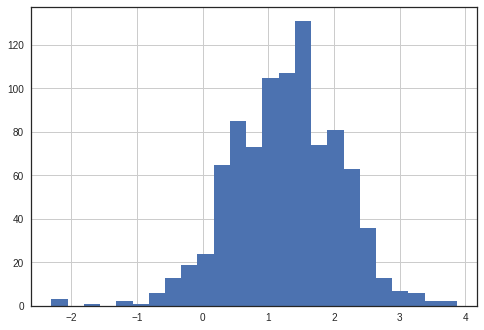

In [25]:
rrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25);

전통적인 접근들 

randon 노출에 대한 2개의 전톡적인 모델링은 bias-variance trade off 두 극단적인 값을 표현한다.  

##  Complete pooling 
Treat all counties the same, and estimate a single radon level.

$ y_i = \alpha + \beta x_i + \epsilon_i $

##  No pooling
Model radon in each county independently.

$ y_i = \alpha_{j[i]}+\beta x_i + \epsilon_i \quad    j = 1,\ ...\ , 85$

The errors $\epsilon_i $ may represent measurement error, temporal within-house variation, or variation among houses.




**Complete  poolong **

slope , intercept





In [0]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform

floor = srrs_mn.floor.values
log_radon = srrs_mn.log_radon.values



In [0]:
with Model() as pooled_model:

    beta = Normal('beta', 0, sd=1e5, shape=2)
    sigma = HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*floor

    y = Normal('y', theta, sd=sigma, observed=log_radon)

In [31]:
with pooled_model:
    pooled_trace = sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta]
100%|██████████| 2000/2000 [00:01<00:00, 1184.09it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


In [33]:
b0, m0 = pooled_trace['beta'].mean(axis=0)


1.3637361516525905

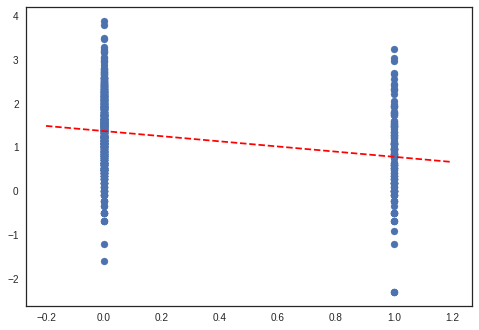

In [34]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');

In [39]:
print(counties)
mn_counties


85


array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR',
       'LINCOLN', 'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD',
       'MEEKER', 'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET',
       'NOBLES', 'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE',
       'PIPESTONE', 'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE',
       'RICE', 'ROCK', 'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY',
       'ST LOUIS', 'STEARNS', 'STEELE', 'STEVENS', 'SWIFT', 'TODD',
       'TRAVERSE', 'WABASHA', 'WADENA', 'WASECA', 'WASHINGTON',
       'WATONWAN', '

## Estimates of county radon levels for the unpooled model

In [0]:
with Model() as unpooled_model:

    beta0 = Normal('beta0', 0, sd=1e5, shape=counties)
    beta1 = Normal('beta1', 0, sd=1e5)
    sigma = HalfCauchy('sigma', 5)

    theta = beta0[county] + beta1*floor

    y = Normal('y', theta, sd=sigma, observed=log_radon)

In [36]:
with unpooled_model:
    unpooled_trace = sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta1, beta0]
100%|██████████| 2000/2000 [00:04<00:00, 469.61it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


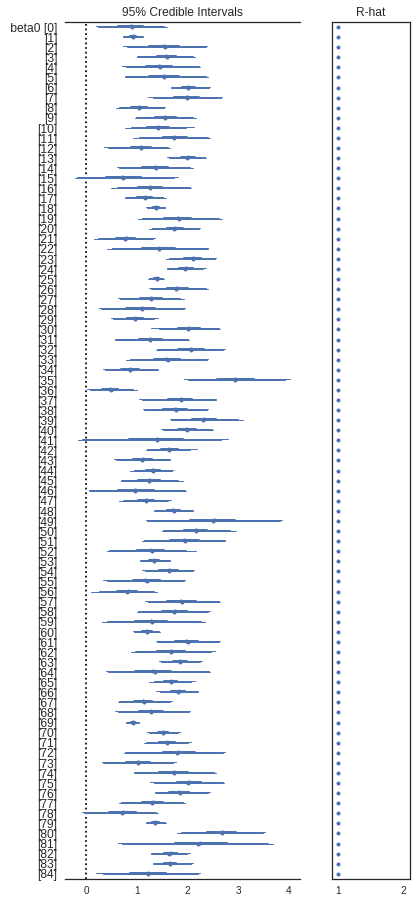

In [40]:
from pymc3 import forestplot

plt.figure(figsize=(6,14))
forestplot(unpooled_trace, varnames=['beta0']);

In [47]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=mn_counties)
unpooled_trace['beta0'].shape

(2000, 85)

In [0]:
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=mn_counties)

In [49]:
order = unpooled_estimates.sort_values().index
print(order)

Index(['LAKE', 'WASECA', 'COOK', 'FARIBAULT', 'PINE', 'KOOCHICHING', 'AITKIN',
       'ST LOUIS', 'ANOKA', 'ITASCA', 'MILLE LACS', 'SWIFT', 'CARLTON',
       'CHISAGO', 'ISANTI', 'MARTIN', 'SHERBURNE', 'CROW WING', 'MORRISON',
       'PENNINGTON', 'RAMSEY', 'YELLOW MEDICINE', 'MEEKER', 'COTTONWOOD',
       'KANABEC', 'HUBBARD', 'SIBLEY', 'NORMAN', 'POPE', 'WADENA', 'MCLEOD',
       'ROCK', 'OLMSTED', 'WASHINGTON', 'CLEARWATER', 'DAKOTA', 'HENNEPIN',
       'MAHNOMEN', 'CASS', 'FILLMORE', 'BENTON', 'STEARNS', 'BIG STONE',
       'BECKER', 'CARVER', 'BELTRAMI', 'KITTSON', 'STEELE', 'OTTER TAIL',
       'MARSHALL', 'WINONA', 'WRIGHT', 'ROSEAU', 'RENVILLE', 'MOWER', 'TODD',
       'POLK', 'CHIPPEWA', 'DOUGLAS', 'LE SUEUR', 'HOUSTON', 'DODGE',
       'STEVENS', 'SCOTT', 'WABASHA', 'RICE', 'LAKE OF THE WOODS', 'PIPESTONE',
       'NOBLES', 'GOODHUE', 'LYON', 'REDWOOD', 'BROWN', 'CLAY', 'BLUE EARTH',
       'TRAVERSE', 'JACKSON', 'KANDIYOHI', 'FREEBORN', 'NICOLLET', 'WILKIN',
       'LINCOLN'

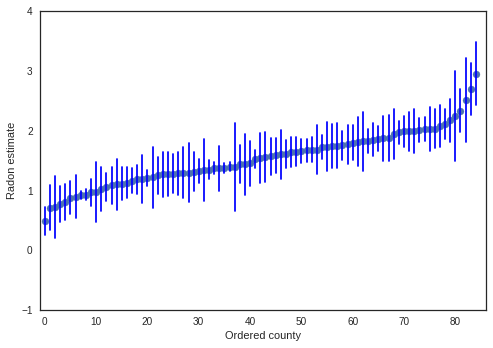

In [50]:
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.



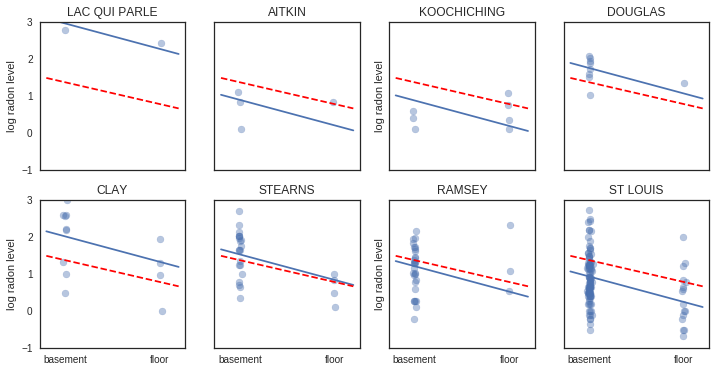

In [51]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates[c]

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)  ## unpooled
    axes[i].plot(xvals, m0*xvals+b0, 'r--') ## pool
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

if we are trying to identify high-radon counties, pooling is useless  

we do not trust extreme unpooled estimates produced by models using few observations  
